In [ ]:
import sys, os, glob, time, imageio 
import numpy as np, pandas as pd  
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image 
import torch 
import torchvision.utils as vutils 
import torchvision.transforms as transforms 
from keras import models, layers, optimizers 
from keras.models import Sequential 
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import tensorflow as tf 
import matplotlib.pyplot as plt
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ds1 = '/content/drive/MyDrive/Data/test/adenocarcinoma'
ds2 = '/content/drive/MyDrive/chest_xray/chest_xray/test/PNEUMONIA'
ds3 = '/content/drive/MyDrive/lung'
ds4 = '/content/drive/MyDrive/gaussian_filtered_images/gaussian_filtered_images/No_DR'

In [ ]:
im1 = "/content/ct.png"
im2 = "/content/Xray.jpeg"
im3 = "/content/tissue.jpeg"
im4 = "/content/rett.png"

In [ ]:
def rand_f(path):
  li = []
  for _ in range(5):
    random_filename = random.choice([x for x in os.listdir(path) if os.path.isfile(os.path.join(path, x))])
    li.append(random_filename)
  print(li)
  return li

In [ ]:
li = rand_f(ds1)

['000084.png', '000158.png', '000091 (7) (1).png', '000051 (3).png', '000058 (5) (1).png']


In [ ]:
def img_identify(path):
    li2 = []
    import random, os


    for i in range(4):
        cmp_img_path = ""+eval("im" + str(i+1))
        cmp_image = img_to_array(load_img(cmp_img_path, target_size = (128,128)))
        cmp_image = tf.convert_to_tensor(cmp_image, dtype = tf.float32)
        s = 0
        for img in li:
            img_path = path+ "/" +img
            image = img_to_array(load_img(img_path, target_size = (128,128)))
            image = tf.convert_to_tensor(image, dtype = tf.float32)
        
            ssim = tf.image.ssim(image, cmp_image, max_val = 1.0, filter_size = 11, filter_sigma = 0.5, k1 = 0.01, )
            s = s + ssim.numpy()
        
        li2.append(s)

    pos = np.argmax(li2) + 1
    if pos == 1:
        path_root = ds1
        print("The dataset is of CT scan")
    elif pos == 2:
        path_root = ds2
        print("The dataset is of X rays")
    elif pos==3:
        path_root = ds3
        print("The dataset is of lung tissues")
    elif pos==4:
        path_root = ds4
        print("The dataset is of retina")
    return path_root

In [ ]:
path_root = img_identify(ds1)

The dataset is of CT scan


In [ ]:
if li[0].find(".png")!=-1:
  imgs_normal = glob.glob(path_root+'/*.png', recursive=True)
elif li[0].find(".jpeg")!=-1:
  imgs_normal = glob.glob(path_root+'/*.jpeg', recursive=True)
else:
  imgs_normal = glob.glob(path_root+'/*.jpg', recursive=True)

print('The dataset contains {:04d} images in total'.format(len(imgs_normal)))

The dataset contains 0521 images in total


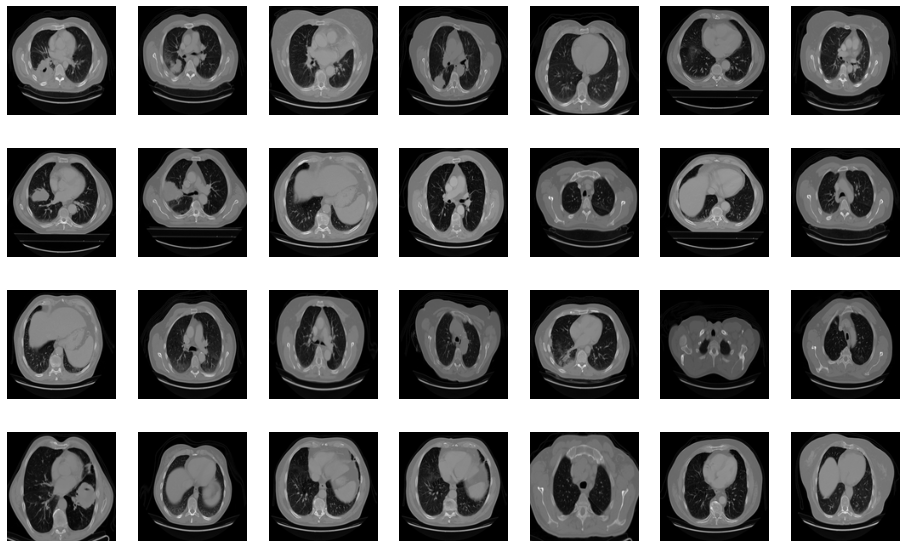

In [ ]:
nrows, ncols = 4, 7
plt.figure(figsize=(16,10))
for idx, name in enumerate(imgs_normal[:nrows*ncols]):
    plt.subplot(nrows, ncols, idx+1)
    img = Image.open(name) # or use plt.imread(path_test+'NORMAL/'+name)
    img = img.resize(size=(128, 128), resample=Image.ANTIALIAS, box=None)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

In [ ]:
# Time 
def _time(start, end): 
    # if in seconds 
    if (end-start)<60: 
        wall_time = f'{round((end-start),2)}sec'
    # if in minute(s)  
    elif (end-start)>=3600: 
        wall_time = f'{int((end-start)/3600)}h {int(((end-start)%3600)/60)}min {round((end-start)%60,2)}sec'
    # if in houre(s)  
    else: 
        wall_time = f'{int((end-start)/60)}min {round((end-start)%60,2)}sec'
    return wall_time 

In [ ]:
def get_dataset(data_path, dim=(128, 128), rand_shuffle=True): 
    start = time.time() 
    imgs_data = []
    sample_size = len(data_path)
    for idx, im_path in enumerate(data_path): 
        if idx%(sample_size//10)==0:
            print('Processing index {:05d} of {:05d} ==> {:03d}%'.format(idx, sample_size, round(100*idx/sample_size))) 
        img = img_to_array(load_img(im_path, target_size = dim)) 
        imgs_data.append(img) 
        
    # convert to float 
    imgs_data = np.array(imgs_data).astype('float32') 
    # scale to [0,1] (note the . after 255 - float)
    imgs_data = imgs_data/255. #for formalizing to [-1,1] ==> (imgs_data - 127.5)/127.5 
    
    # shuffle the data 
    if rand_shuffle: 
        idx = np.arange(imgs_data.shape[0])
        np.random.shuffle(idx) 
        imgs_data = imgs_data[idx,:,:,:] 
    
    print(f"The calculations are completed in {_time(start, time.time())}")
    return imgs_data  

In [ ]:
print('Initiating...')
X_normal = get_dataset(imgs_normal)

Starting for images ...
Processing index 00000 of 00521 ==> 000%
Processing index 00052 of 00521 ==> 010%
Processing index 00104 of 00521 ==> 020%
Processing index 00156 of 00521 ==> 030%
Processing index 00208 of 00521 ==> 040%
Processing index 00260 of 00521 ==> 050%
Processing index 00312 of 00521 ==> 060%
Processing index 00364 of 00521 ==> 070%
Processing index 00416 of 00521 ==> 080%
Processing index 00468 of 00521 ==> 090%
Processing index 00520 of 00521 ==> 100%
Hey! the calculations are done in 2.28sec


In [ ]:
def define_grid(data_images, nrows=4, ncols=5, plot_grid=True):
    # save the started time 
    start = time.time() 
    # Number of GPUs available. Use 0 for CPU mode. 
    ngpu = 1 
    # Decide which device we want to run on 
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    # Rearange the shaphe of the data 
    data_transp = [np.transpose(data_images[i,:,:]) for i in range(data_images[:nrows*ncols].shape[0])]
    # From to torch type for the grid 
    data_transp = torch.Tensor(data_transp)
    print(f'The shape is reordered from {data_images.shape[1:]} to {data_transp.shape[1:]} in {_time(start, time.time())}')
    
    # Make the grid 
    grid_images = np.transpose(
        vutils.make_grid(
            data_transp.to(device)[:nrows*ncols], 
            nrow=nrows,
            padding=2,
            normalize=True,
            scale_each=True,
            pad_value=1,
        ).cpu(), axes=(2,1,0))
        
    # Show the output grid 
    if plot_grid:
        plt.figure(figsize=(12,12)) 
        plt.axis("off") 
        plt.title(f'Grid of {nrows*ncols} real images', fontsize=27)
        plt.imshow(grid_images)
        
    return grid_images

grid_X_normal = define_grid(X_normal, plot_grid=False)

The shape is reordered from (128, 128, 3) to torch.Size([3, 128, 128]) in 0.08sec


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  # This is added back by InteractiveShellApp.init_path()


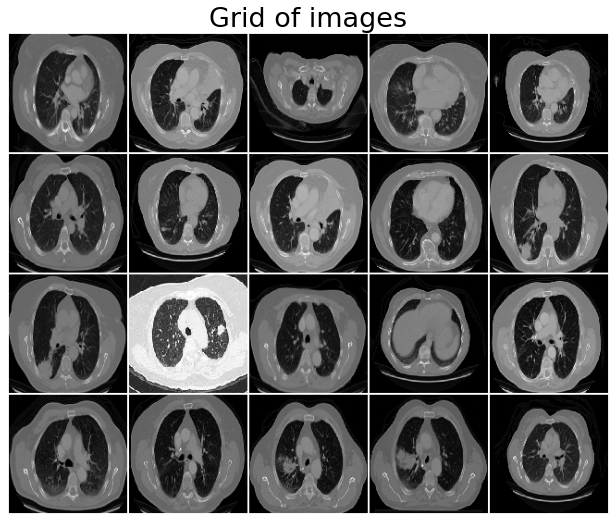

In [ ]:
fig, ax1 = plt.subplots(figsize=(19, 8))

ax1.imshow(grid_X_normal); ax1.axis('off')
ax1.set_title(label = 'Grid of images', fontsize = 27)

plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=[0, 0.03, 1, 0.95])

In [ ]:
n_epoch = 150 

batch_size = 128 

latent_dim = 1000

cols, rows = 128, 128 

channels = 3 

dim = cols, rows # height, width 

in_shape = (cols, rows, channels) # height, width, color 

lr = 3e-4

beta1 = 0.5

ngpu = 1 

nrows, ncols = 3, 4

In [ ]:
def define_discriminator(in_shape=(128,128,3)): 
    model = models.Sequential() 
    # normal 
    model.add(layers.Conv2D(128, (5,5), padding='same', input_shape=in_shape)) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # downsample to 64x64 
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # downsample to 32x32 
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # downsample to 16x16 
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # downsample to 8x8 
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # classifier 
    model.add(layers.Flatten()) 
    model.add(layers.Dropout(0.4)) 
    model.add(layers.Dense(1, activation='sigmoid')) 
    # compile model 
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) 
    return model

In [ ]:
def define_generator(latent_dim):
    model = models.Sequential()
    # foundation for 8x8 feature maps
    n_nodes = 128*8*8
    model.add(layers.Dense(n_nodes, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((8, 8, 128)))
    # upsample to 16x16
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 128x128
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # output layer 128x128x3
    model.add(layers.Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model 


In [ ]:
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim*n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input 

In [ ]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

In [ ]:
def define_gan(g_model, d_model): 
    # make weights in the discriminator not trainable
    d_model.trainable = False 
    # connect them
    model = models.Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [ ]:
def get_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # set 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y


In [ ]:
def show_generated(generated, epoch, nrows=4, ncols=5):
    #[-1,1] -> [0,1] 
    #generated = (generated+1)/2 
    #generated = (generated[:ncols*nrows]*127.5)+127.5 
    #generated = generated*255 
    plt.figure(figsize=(10,10)) 
    for idx in range(nrows*ncols): 
        plt.subplot(nrows, ncols, idx+1) 
        plt.imshow(generated[idx]) 
        plt.axis('off') 
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1)) 
    plt.show() 

# evaluate the discriminator and plot generated images 
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = get_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples 
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples 
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples 
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance 
    print('> Accuracy at epoch %d [real: %.0f%%, fake: %.0f%%]'%(epoch+1, acc_real*100, acc_fake*100))
    # show plot 
    show_generated(x_fake, epoch)  
    
def plot_loss(loss):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training", fontsize=20) 
    plt.plot(loss[0], label="D_real") 
    plt.plot(loss[1], label="D_fake") 
    plt.plot(loss[2], label="G") 
    plt.xlabel("Iteration", fontsize=20); plt.ylabel("Loss", fontsize=20) 
    plt.legend(); plt.show() 

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim=100, n_epochs=100, n_batch=128):
    
    start = time.time() 
    bat_per_epo = int(dataset.shape[0]/n_batch) 
    half_batch = int(n_batch/2) 
    loss1, loss2, loss3 = [], [], [] 
    fake_liste = [] 
    
    # manually enumerate epochs
    print('Training Start...')
    for i in range(n_epochs):
        start1 = time.time()
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = get_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            loss1.append(d_loss1); loss2.append(d_loss2); loss3.append(g_loss) 
        
        print('Epoch: {:03d}/{:03d}, Loss: [D_real = {:2.3f}, D_fake = {:2.3f}, G = {:2.3f}], time: {:s}'\
              .format(i+1,n_epochs,d_loss1,d_loss2,g_loss, _time(start1,time.time())))
        # evaluate the model performance 
        if (i+1)%(n_epochs//10) == 0: 
            # Save and show generated images 
            summarize_performance(i, g_model, d_model, dataset, latent_dim) 
        
    print('Total time for training {} epochs is {} sec'.format(n_epochs, _time(start, time.time())))

    loss = (loss1, loss2, loss3) 
    plot_loss(loss)

In [ ]:
discriminator = define_discriminator() 
generator = define_generator(latent_dim) 

# create the gan 
gan = define_gan(generator, discriminator)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training Start...
Epoch: 001/150, Loss: [D_real = 0.014, D_fake = 0.876, G = 0.605], time: 26.74sec
Epoch: 002/150, Loss: [D_real = 0.307, D_fake = 1.019, G = 0.620], time: 6.4sec
Epoch: 003/150, Loss: [D_real = 0.357, D_fake = 0.599, G = 0.975], time: 6.38sec
Epoch: 004/150, Loss: [D_real = 0.140, D_fake = 0.687, G = 0.706], time: 6.41sec
Epoch: 005/150, Loss: [D_real = 0.002, D_fake = 0.674, G = 0.719], time: 6.47sec
Epoch: 006/150, Loss: [D_real = 0.000, D_fake = 0.622, G = 0.821], time: 6.44sec
Epoch: 007/150, Loss: [D_real = 0.000, D_fake = 0.375, G = 1.847], time: 6.46sec
Epoch: 008/150, Loss: [D_real = 29.591, D_fake = 0.312, G = 0.631], time: 6.52sec
Epoch: 009/150, Loss: [D_real = 0.028, D_fake = 0.728, G = 0.759], time: 6.55sec
Epoch: 010/150, Loss: [D_real = 0.027, D_fake = 0.588, G = 0.896], time: 6.53sec
Epoch: 011/150, Loss: [D_real = 0.015, D_fake = 0.244, G = 1.899], time: 6.52sec
Epoch: 012/150, Loss: [D_real = 0.009, D_fake = 0.084, G = 2.903], time: 6.53sec
Epoch: 01

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 15 [real: 96%, fake: 77%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


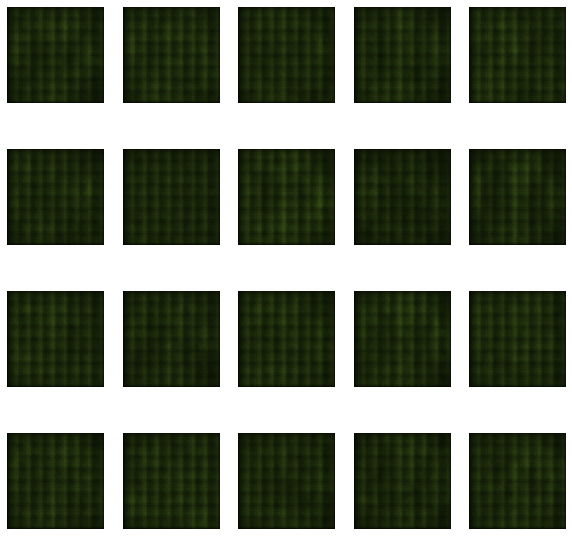

Epoch: 016/150, Loss: [D_real = 0.077, D_fake = 0.584, G = 0.959], time: 6.6sec
Epoch: 017/150, Loss: [D_real = 0.045, D_fake = 0.551, G = 1.099], time: 7.39sec
Epoch: 018/150, Loss: [D_real = 0.020, D_fake = 0.590, G = 1.067], time: 6.83sec
Epoch: 019/150, Loss: [D_real = 0.122, D_fake = 0.567, G = 1.570], time: 6.61sec
Epoch: 020/150, Loss: [D_real = 0.118, D_fake = 0.633, G = 1.886], time: 6.69sec
Epoch: 021/150, Loss: [D_real = 0.485, D_fake = 0.817, G = 1.778], time: 6.64sec
Epoch: 022/150, Loss: [D_real = 0.587, D_fake = 1.138, G = 2.432], time: 6.73sec
Epoch: 023/150, Loss: [D_real = 0.670, D_fake = 0.176, G = 3.138], time: 6.66sec
Epoch: 024/150, Loss: [D_real = 0.249, D_fake = 0.436, G = 1.580], time: 6.66sec
Epoch: 025/150, Loss: [D_real = 0.322, D_fake = 0.475, G = 1.552], time: 6.66sec
Epoch: 026/150, Loss: [D_real = 0.479, D_fake = 0.374, G = 1.886], time: 7.21sec
Epoch: 027/150, Loss: [D_real = 0.377, D_fake = 0.564, G = 2.038], time: 6.79sec
Epoch: 028/150, Loss: [D_real

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 30 [real: 96%, fake: 91%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


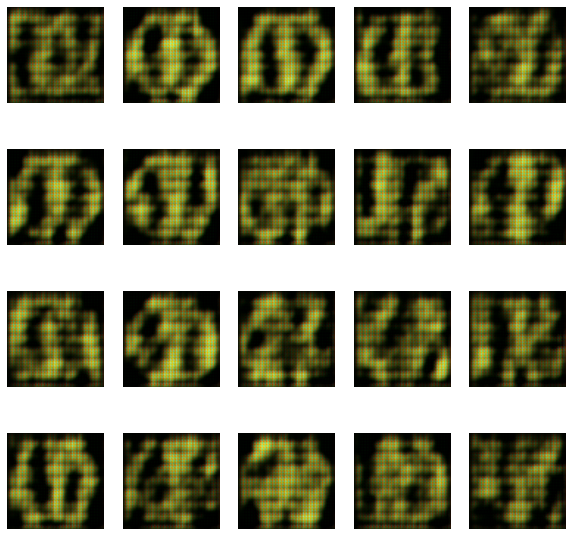

Epoch: 031/150, Loss: [D_real = 0.061, D_fake = 0.203, G = 2.492], time: 6.75sec
Epoch: 032/150, Loss: [D_real = 0.241, D_fake = 0.666, G = 3.198], time: 6.7sec
Epoch: 033/150, Loss: [D_real = 0.588, D_fake = 0.764, G = 1.543], time: 6.73sec
Epoch: 034/150, Loss: [D_real = 0.484, D_fake = 0.594, G = 1.473], time: 6.75sec
Epoch: 035/150, Loss: [D_real = 0.492, D_fake = 0.726, G = 1.407], time: 6.71sec
Epoch: 036/150, Loss: [D_real = 0.439, D_fake = 0.597, G = 1.463], time: 6.76sec
Epoch: 037/150, Loss: [D_real = 0.501, D_fake = 0.534, G = 1.489], time: 7.07sec
Epoch: 038/150, Loss: [D_real = 0.675, D_fake = 0.493, G = 1.711], time: 6.73sec
Epoch: 039/150, Loss: [D_real = 0.720, D_fake = 0.642, G = 1.861], time: 6.74sec
Epoch: 040/150, Loss: [D_real = 0.689, D_fake = 0.601, G = 1.698], time: 6.72sec
Epoch: 041/150, Loss: [D_real = 0.504, D_fake = 0.619, G = 1.454], time: 6.72sec
Epoch: 042/150, Loss: [D_real = 0.545, D_fake = 0.581, G = 1.293], time: 6.72sec
Epoch: 043/150, Loss: [D_real

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 45 [real: 86%, fake: 97%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


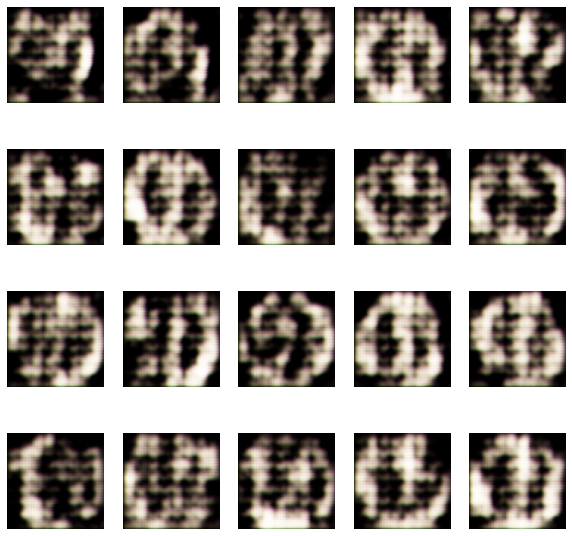

Epoch: 046/150, Loss: [D_real = 0.436, D_fake = 0.672, G = 1.594], time: 6.77sec
Epoch: 047/150, Loss: [D_real = 1.012, D_fake = 0.598, G = 1.742], time: 6.76sec
Epoch: 048/150, Loss: [D_real = 0.462, D_fake = 0.334, G = 2.028], time: 6.73sec
Epoch: 049/150, Loss: [D_real = 0.447, D_fake = 0.422, G = 1.928], time: 6.71sec
Epoch: 050/150, Loss: [D_real = 0.362, D_fake = 0.466, G = 2.083], time: 7.07sec
Epoch: 051/150, Loss: [D_real = 0.341, D_fake = 0.312, G = 2.100], time: 6.71sec
Epoch: 052/150, Loss: [D_real = 0.570, D_fake = 0.422, G = 2.376], time: 6.72sec
Epoch: 053/150, Loss: [D_real = 0.641, D_fake = 0.489, G = 2.369], time: 6.73sec
Epoch: 054/150, Loss: [D_real = 0.340, D_fake = 0.687, G = 3.057], time: 6.72sec
Epoch: 055/150, Loss: [D_real = 0.337, D_fake = 0.296, G = 2.110], time: 6.76sec
Epoch: 056/150, Loss: [D_real = 0.363, D_fake = 0.401, G = 3.062], time: 6.72sec
Epoch: 057/150, Loss: [D_real = 0.411, D_fake = 0.344, G = 2.171], time: 6.72sec
Epoch: 058/150, Loss: [D_rea

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 60 [real: 20%, fake: 99%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

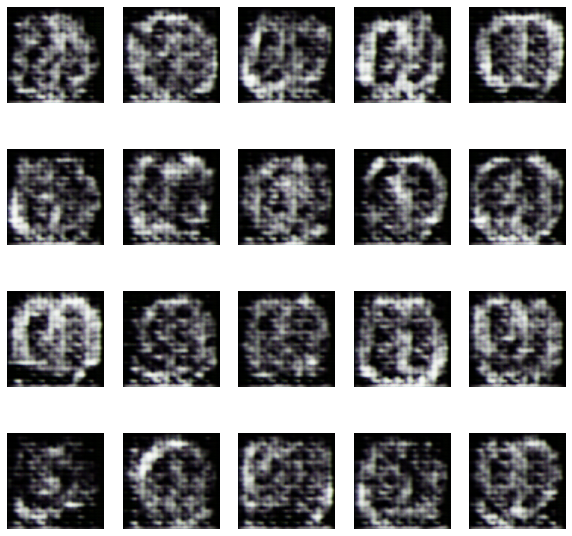

Epoch: 061/150, Loss: [D_real = 0.431, D_fake = 0.336, G = 2.600], time: 6.78sec
Epoch: 062/150, Loss: [D_real = 0.296, D_fake = 0.269, G = 2.887], time: 6.71sec
Epoch: 063/150, Loss: [D_real = 0.230, D_fake = 0.279, G = 2.367], time: 6.72sec
Epoch: 064/150, Loss: [D_real = 0.522, D_fake = 0.277, G = 2.194], time: 6.72sec
Epoch: 065/150, Loss: [D_real = 2.224, D_fake = 0.307, G = 2.958], time: 6.73sec
Epoch: 066/150, Loss: [D_real = 0.286, D_fake = 0.553, G = 2.175], time: 6.81sec
Epoch: 067/150, Loss: [D_real = 0.526, D_fake = 0.141, G = 2.976], time: 6.72sec
Epoch: 068/150, Loss: [D_real = 0.763, D_fake = 0.680, G = 2.581], time: 6.79sec
Epoch: 069/150, Loss: [D_real = 0.229, D_fake = 0.526, G = 2.837], time: 6.78sec
Epoch: 070/150, Loss: [D_real = 0.279, D_fake = 0.363, G = 2.056], time: 6.76sec
Epoch: 071/150, Loss: [D_real = 0.334, D_fake = 0.262, G = 2.391], time: 6.73sec
Epoch: 072/150, Loss: [D_real = 0.288, D_fake = 0.248, G = 2.510], time: 6.73sec
Epoch: 073/150, Loss: [D_rea

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 75 [real: 97%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

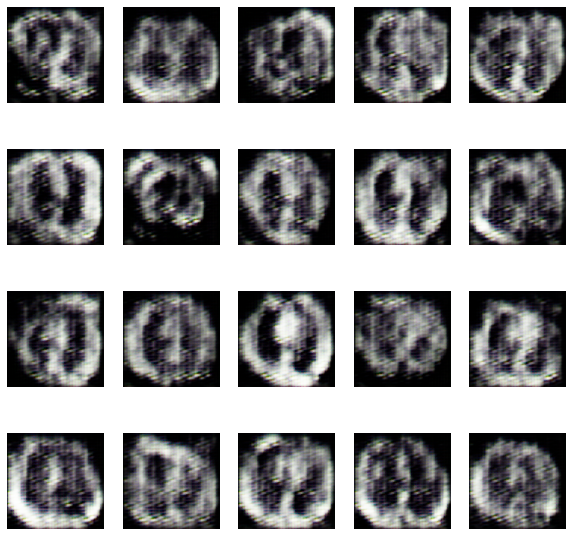

Epoch: 076/150, Loss: [D_real = 0.323, D_fake = 0.207, G = 2.569], time: 7.12sec
Epoch: 077/150, Loss: [D_real = 1.418, D_fake = 2.414, G = 2.601], time: 6.73sec
Epoch: 078/150, Loss: [D_real = 0.219, D_fake = 0.339, G = 2.811], time: 6.76sec
Epoch: 079/150, Loss: [D_real = 0.311, D_fake = 0.207, G = 2.520], time: 6.73sec
Epoch: 080/150, Loss: [D_real = 0.279, D_fake = 0.201, G = 2.499], time: 6.72sec
Epoch: 081/150, Loss: [D_real = 0.201, D_fake = 0.179, G = 3.002], time: 6.73sec
Epoch: 082/150, Loss: [D_real = 0.185, D_fake = 0.175, G = 3.366], time: 6.71sec
Epoch: 083/150, Loss: [D_real = 0.340, D_fake = 0.266, G = 2.826], time: 6.75sec
Epoch: 084/150, Loss: [D_real = 1.241, D_fake = 1.996, G = 3.432], time: 6.72sec
Epoch: 085/150, Loss: [D_real = 0.301, D_fake = 0.319, G = 2.924], time: 6.71sec
Epoch: 086/150, Loss: [D_real = 0.471, D_fake = 0.283, G = 2.273], time: 6.72sec
Epoch: 087/150, Loss: [D_real = 0.318, D_fake = 0.199, G = 2.575], time: 6.7sec
Epoch: 088/150, Loss: [D_real

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 90 [real: 72%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

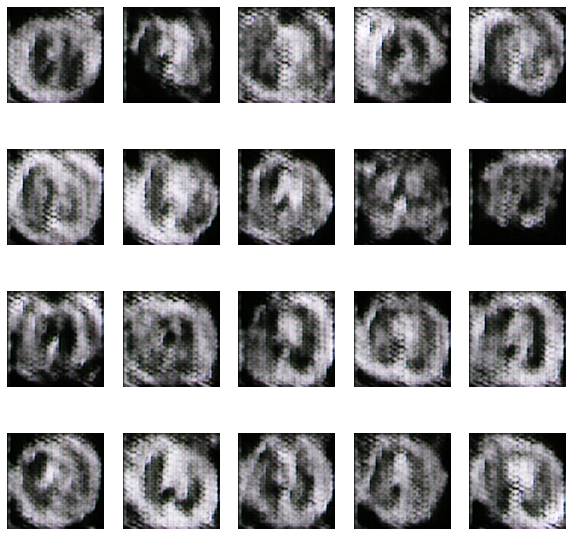

Epoch: 091/150, Loss: [D_real = 0.145, D_fake = 0.187, G = 3.320], time: 6.75sec
Epoch: 092/150, Loss: [D_real = 0.155, D_fake = 0.100, G = 3.380], time: 6.72sec
Epoch: 093/150, Loss: [D_real = 0.246, D_fake = 0.319, G = 3.595], time: 6.76sec
Epoch: 094/150, Loss: [D_real = 0.164, D_fake = 0.115, G = 3.346], time: 6.72sec
Epoch: 095/150, Loss: [D_real = 0.504, D_fake = 0.576, G = 3.290], time: 6.72sec
Epoch: 096/150, Loss: [D_real = 0.212, D_fake = 0.327, G = 4.304], time: 6.76sec
Epoch: 097/150, Loss: [D_real = 0.092, D_fake = 0.169, G = 3.647], time: 6.73sec
Epoch: 098/150, Loss: [D_real = 0.188, D_fake = 0.087, G = 3.284], time: 6.71sec
Epoch: 099/150, Loss: [D_real = 0.125, D_fake = 0.118, G = 3.640], time: 6.71sec
Epoch: 100/150, Loss: [D_real = 0.116, D_fake = 0.164, G = 4.446], time: 6.72sec
Epoch: 101/150, Loss: [D_real = 0.181, D_fake = 0.240, G = 4.072], time: 6.76sec
Epoch: 102/150, Loss: [D_real = 0.488, D_fake = 0.714, G = 3.146], time: 6.71sec
Epoch: 103/150, Loss: [D_rea

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 105 [real: 86%, fake: 84%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


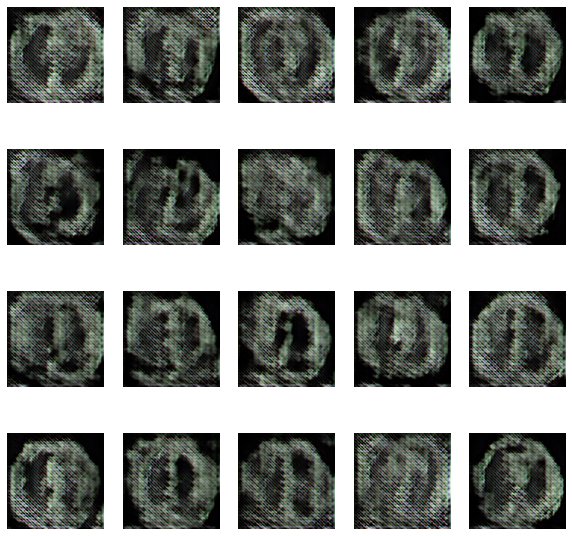

Epoch: 106/150, Loss: [D_real = 0.265, D_fake = 0.355, G = 3.072], time: 6.72sec
Epoch: 107/150, Loss: [D_real = 0.239, D_fake = 0.287, G = 3.657], time: 6.71sec
Epoch: 108/150, Loss: [D_real = 0.219, D_fake = 0.182, G = 3.218], time: 6.72sec
Epoch: 109/150, Loss: [D_real = 0.224, D_fake = 0.303, G = 3.767], time: 6.71sec
Epoch: 110/150, Loss: [D_real = 0.294, D_fake = 0.343, G = 3.487], time: 6.71sec
Epoch: 111/150, Loss: [D_real = 0.097, D_fake = 0.193, G = 3.911], time: 6.95sec
Epoch: 112/150, Loss: [D_real = 0.248, D_fake = 0.258, G = 3.946], time: 6.76sec
Epoch: 113/150, Loss: [D_real = 0.100, D_fake = 0.034, G = 4.838], time: 6.73sec
Epoch: 114/150, Loss: [D_real = 0.572, D_fake = 0.899, G = 2.676], time: 6.76sec
Epoch: 115/150, Loss: [D_real = 0.184, D_fake = 0.201, G = 4.066], time: 6.72sec
Epoch: 116/150, Loss: [D_real = 0.158, D_fake = 0.164, G = 3.859], time: 6.77sec
Epoch: 117/150, Loss: [D_real = 0.169, D_fake = 0.101, G = 3.706], time: 6.71sec
Epoch: 118/150, Loss: [D_rea

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 120 [real: 95%, fake: 99%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


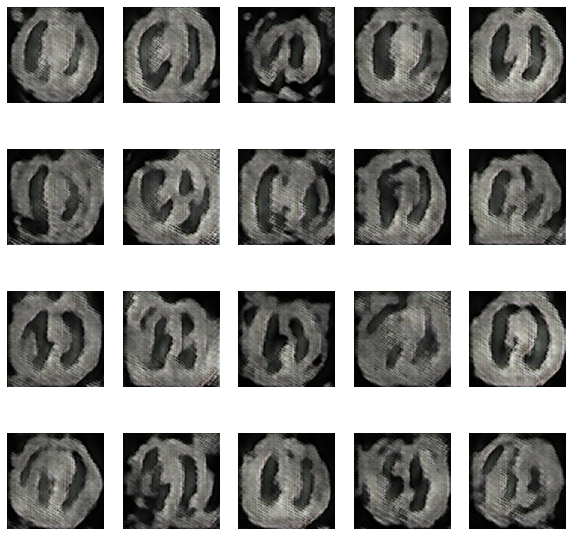

Epoch: 121/150, Loss: [D_real = 0.182, D_fake = 0.371, G = 4.898], time: 6.69sec
Epoch: 122/150, Loss: [D_real = 0.072, D_fake = 0.168, G = 4.387], time: 6.7sec
Epoch: 123/150, Loss: [D_real = 0.196, D_fake = 0.186, G = 3.613], time: 6.75sec
Epoch: 124/150, Loss: [D_real = 0.179, D_fake = 0.214, G = 3.912], time: 6.75sec
Epoch: 125/150, Loss: [D_real = 0.089, D_fake = 0.175, G = 4.478], time: 6.76sec
Epoch: 126/150, Loss: [D_real = 0.301, D_fake = 0.243, G = 4.056], time: 6.71sec
Epoch: 127/150, Loss: [D_real = 0.122, D_fake = 2.619, G = 9.608], time: 6.76sec
Epoch: 128/150, Loss: [D_real = 0.722, D_fake = 0.708, G = 0.993], time: 6.71sec
Epoch: 129/150, Loss: [D_real = 0.350, D_fake = 0.785, G = 0.717], time: 6.71sec
Epoch: 130/150, Loss: [D_real = 0.363, D_fake = 0.785, G = 0.705], time: 6.71sec
Epoch: 131/150, Loss: [D_real = 0.254, D_fake = 0.723, G = 0.744], time: 6.71sec
Epoch: 132/150, Loss: [D_real = 0.256, D_fake = 0.711, G = 0.832], time: 6.75sec
Epoch: 133/150, Loss: [D_real

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 135 [real: 89%, fake: 93%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


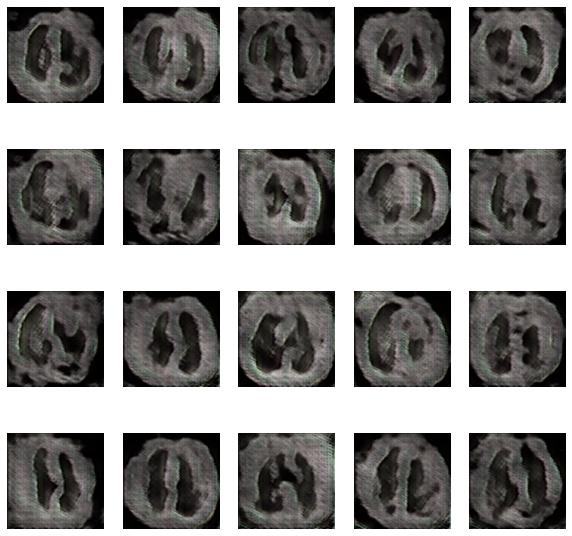

Epoch: 136/150, Loss: [D_real = 0.458, D_fake = 0.552, G = 1.080], time: 6.71sec
Epoch: 137/150, Loss: [D_real = 0.352, D_fake = 0.518, G = 1.300], time: 6.74sec
Epoch: 138/150, Loss: [D_real = 0.328, D_fake = 0.421, G = 1.443], time: 6.75sec
Epoch: 139/150, Loss: [D_real = 0.289, D_fake = 0.434, G = 1.649], time: 6.71sec
Epoch: 140/150, Loss: [D_real = 0.307, D_fake = 0.346, G = 1.863], time: 6.75sec
Epoch: 141/150, Loss: [D_real = 0.304, D_fake = 0.411, G = 1.832], time: 6.72sec
Epoch: 142/150, Loss: [D_real = 0.393, D_fake = 0.402, G = 1.821], time: 6.71sec
Epoch: 143/150, Loss: [D_real = 0.330, D_fake = 0.492, G = 2.401], time: 6.72sec
Epoch: 144/150, Loss: [D_real = 0.253, D_fake = 0.225, G = 2.436], time: 6.72sec
Epoch: 145/150, Loss: [D_real = 0.305, D_fake = 0.279, G = 2.370], time: 6.73sec
Epoch: 146/150, Loss: [D_real = 0.266, D_fake = 0.281, G = 2.537], time: 6.75sec
Epoch: 147/150, Loss: [D_real = 0.221, D_fake = 0.316, G = 2.498], time: 6.72sec
Epoch: 148/150, Loss: [D_rea

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 150 [real: 95%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

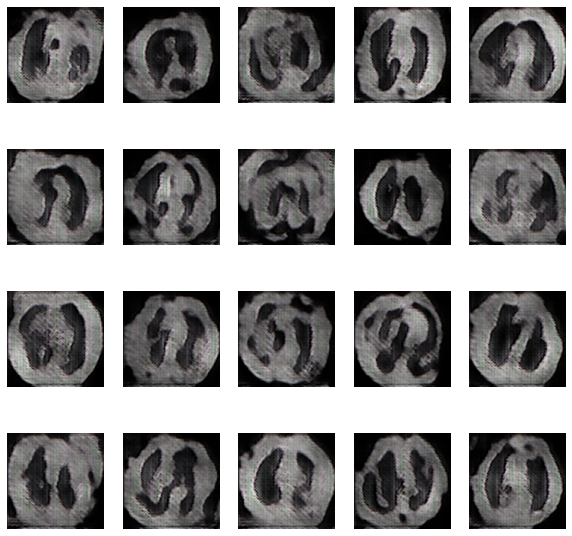

Total time for training 150 epochs is 17min 28.32sec sec


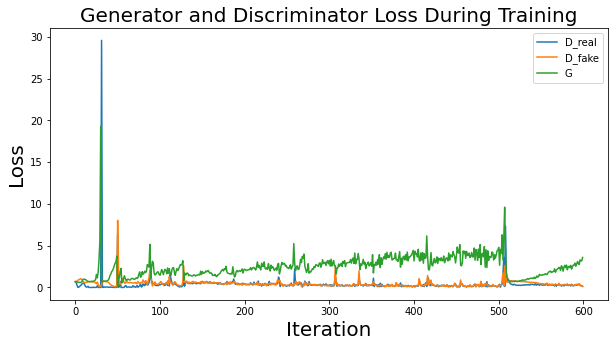

In [ ]:
# train model 
train(generator, discriminator, gan, X_normal, latent_dim, n_epochs=n_epoch, n_batch=batch_size)

In [ ]:
fake_path = glob.glob('/content/image_at_epoch*.png')
fake_imgs = get_dataset(sorted(fake_path), rand_shuffle=False)

Processing index 00000 of 00010 ==> 000%
Processing index 00001 of 00010 ==> 010%
Processing index 00002 of 00010 ==> 020%
Processing index 00003 of 00010 ==> 030%
Processing index 00004 of 00010 ==> 040%
Processing index 00005 of 00010 ==> 050%
Processing index 00006 of 00010 ==> 060%
Processing index 00007 of 00010 ==> 070%
Processing index 00008 of 00010 ==> 080%
Processing index 00009 of 00010 ==> 090%
Hey! the calculations are done in 0.22sec


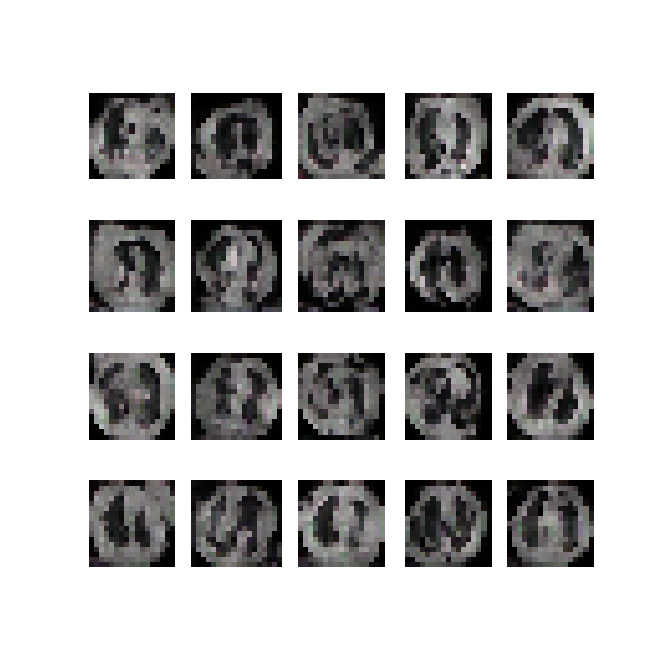

In [ ]:
fake_transp = [np.transpose(fake_imgs[i,:,:]) for i in range(fake_imgs.shape[0])]

fig = plt.figure(figsize=(12,12)) 
plt.axis("off") 
imgs = [[plt.imshow(np.transpose(i,(2,1,0)), animated=True)] for i in fake_transp] 
ani = animation.ArtistAnimation(fig, imgs, interval=1000, repeat_delay=1000, blit=True) 

HTML(ani.to_jshtml())

In [ ]:
files = []
n_iter = int(n_epoch/10)
imgs_epochs = glob.glob('/content/image_at_epoch_*.png') 
for img_epoch in imgs_epochs: 
    files.append(imageio.imread(img_epoch)) 
imageio.mimsave('dcgan_celebA_generation_animation.gif', files, fps=5) 

In [ ]:
def imgFakeGenerator(g_model=generator, latent_dim =1000, n_samples=1000, show_gen=False):
    # generate points in latent space 
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs 
    X = g_model.predict(x_input) 
    
    # Show the generated images
    if show_gen and n_samples<=30: 
        ncols = 5
        nrows = int(n_samples/ncols)
        plt.figure(figsize=(12,10)) 
        for idx in range(nrows*ncols): 
            plt.subplot(nrows, ncols, idx+1)
            plt.imshow(X[idx,:,:]); plt.axis('off')
        plt.show();
    return X 

img_fake = imgFakeGenerator(generator, n_samples=20)

In [ ]:
# SAVE TO ZIP FILE 
import zipfile
output_path = zipfile.PyZipFile('/content/imagesFake.zip', mode='w')

img_generated = imgFakeGenerator(n_samples=1000)
for idx in range(img_generated.shape[0]):
    img_NFake  = img_generated[idx,:,:]
    name_NFake = 'generated {:04d}.png'.format(idx)
    imageio.imwrite(name_Fake, img_Fake)
    
    output_path.write(name_Fake)
    os.remove(name_Fake) 
output_path.close()